<a href="https://colab.research.google.com/github/pethodoma/BME-DeepLearning-BirdCLEF_2023/blob/main/preprocess_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install pandas numpy librosa matplotlib tqdm soundfile scipy

In [2]:
# import packages
import pandas as pd
import numpy as np
import os
import librosa.display
import librosa
import matplotlib.pyplot as plt
import random
import math
import json
import time
from tqdm.auto import tqdm
import soundfile as sf
from scipy.signal import butter, lfilter
from tempfile import TemporaryDirectory
import shutil
from PIL import Image

In [3]:
!wget -q -O birdclef.zip https://www.dropbox.com/scl/fi/fyyjnqy2wb15gvucfg67v/birdclef-2023.zip?rlkey=8mg1nnjhyoirucagsj1ro2vy7&dl=0
!unzip -q 'birdclef.zip'

There around 17000 audiofiles in the provided training dataset. About 2000 of them have multiple labels. We decided to exclude them from the training dataset for a simpler input for the neural network and because there is plenty of data at hand. Also, in the metadata of the files there are ratings describing the quality of the sound files. We decided to throw away the files with low ratings.

In [4]:
def read_file_paths(main_directory):
    main_directory = main_directory
    file_paths = []

    # go through all folders and get the paths of all .ogg audio files
    for root, directories, files in os.walk(main_directory):
        for file in files:
            if file.endswith('.ogg'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    # os.walk may not go in alphabetical order thus it needs to be sorted
    file_paths.sort()
    return file_paths

# Function to create the variables and files that log the data preprocessing, and the file for the final samples
def create_logs(filelog_csv_name, sample_counts_json_name, output_folder, child_folders):
    # Creating or reading the variable logging the preprocessing
    if os.path.exists(filelog_csv_name):
        filelog = pd.read_csv(filelog_csv_name).values.tolist()
        print(len(filelog))
    else:
        filelog = []
    # Creating or reading the variable that keeps track of the sample counts for each bird species
    if os.path.exists(sample_counts_json_name):
        with open(sample_counts_json_name, 'r') as json_file:
            sample_counts = json.load(json_file)
    else:
        sample_counts = {}
    # Creating the folder for the final samples
    if not os.path.exists(output_folder):
        os.mkdir(output_folder)
    for child_folder in child_folders:
        if not os.path.exists(os.path.join(output_folder, child_folder)):
            os.mkdir(os.path.join(output_folder, child_folder))

    return filelog, sample_counts

def cleandata(df):

    df = pd.read_csv('train_metadata.csv')
    print("Cleaning data...")

    # delete data with low rating (rating in interval [0.0, 0.5]) from dataframe
    # get the names of the files with a rating of 0.0 or 0.5 - these are the files we want to get rid of
    poorRatingFilenames = df.loc[df['rating'].isin([0.0, 0.5])]['filename'].values.tolist()

    rows_to_delete = df.loc[df['rating'].isin([0.0, 0.5])].index
    df.drop(rows_to_delete, inplace=True)

    # the folder which contains the audio files
    trainpath='train_audio'

    # creating an array of the files to delete with the full path
    FilesToDelete = [os.path.join(subdir, file) for subdir, dirs, files in os.walk(trainpath) for file in files if os.path.basename(subdir)+'/'+file in poorRatingFilenames]

    # delete files with more than 1 labels
    rows_with_multiple_labels = df[df['secondary_labels'].apply(lambda x: len(x) > 2)]
    #print(rows_with_multiple_labels)
    df.drop(rows_with_multiple_labels.index, axis=0, inplace=True)
    files_with_multiple_labels = rows_with_multiple_labels['filename']
    file_array = np.array(files_with_multiple_labels)

    for i in range(len(file_array)):
        file_path = (os.path.join("train_audio/" , file_array[i]))
        FilesToDelete.append(file_path)

    # also delete files that are shorter than 1 sec
    # it takes a lot of time (about 45 mins) to search these files so we built it in the code
    short_files = ["categr/XC368933.ogg","categr/XC368934.ogg","eubeat1/XC647701.ogg","gargan/XC310912.ogg","gobbun1/XC200993.ogg","greegr/XC338469.ogg","litegr/XC147857.ogg","piekin1/XC601791.ogg","rerswa1/XC191112.ogg","strher/XC255388.ogg"]
    for i in range(len(short_files)):
        df.drop(df[df['filename'] == short_files[i]].index, axis=0, inplace=True)
        file_path = os.path.join("train_audio/" , short_files[i])
        if os.path.exists(file_path):
            FilesToDelete.append(file_path)
    FilesToDelete = np.unique(FilesToDelete)

    ## if there aren't any files to delete, then we dont need to do anything - assuming the data path is right
    if len(FilesToDelete) == 0:
        print("Data has already been cleaned")
    else:
        count = 0
        for file in FilesToDelete:
            try:
                if os.path.exists(file):
                    os.remove(file)
                    count += 1
            except FileNotFoundError:
                print(f"FileNotFoundError: {file} not found during deletion")

        if count > 0:
            print(f"Deleted {count} files")
        else:
            print("No files deleted")

    df.to_csv('train_metadata.csv', index=False)
    return df



To make all the inputs to the same size we cut the bird sounds from the original audio files by thresholding the energy. We create the melspectrogram from the audio file and then for every timestep we calculate the energy. Before that, we apply a highpass filter that cuts off every signal below the frequency of 1000 Hz. This helps us avoid extracting segments where the high frame energy was caused by the high amplitude of lower-frequency noises, for example an engine sound. If the frame energy is greater than the threshold value we consider it as a bird sound assuming that the bird sounds are much louder than the background thus they have more energy. By modifying the threshold value we found that the optimum was at 10 times of the median of the energies of all the time steps.

Sometimes birds can make sounds with concatenated chirps that result in longer sequences. We don't want to separate these sequences thus we defined a 0.5 sec time window as a no sound period. If another chirp is present in this no sound period the algorithm handles it as one sequence and concatenates the incoming chirp's time to the sequence.

After that is done, the intervals are passed on to the cut_windows function, which cuts out the equally sized time windows from the original file around the chirp. We have chosen these time windows to be 5 seconds long, as even the longest chirp sequences can fit into this time frame, while it still does not include too much unneccesary data for shorter sequences. The windows are cut out in a way that the individual chirp is always placed into a different part of the window to introduce some variety to the data. The data for the created samples are logged in a pandas dataframe and then saved to a csv file. The number of samples for each secies is logged in a dictionary, which is than saved to a JSON file.

Once that is done, it is investigated whether there is a sufficient number of samples for every species. If not, than a combination of two common audio augmentation methods is used to augment the data. The random gain method changes the volume of the segment randomly, while time shifting shifts the position of the features within the time window. These methods are done by extracting the raw chirps from the corresponding files, randomly modifying their volume and then placing them to a random position within a sample of a 5 seconds long white noise segment.

The functions for these operations are defined below.

In [5]:
# Define a highpass Butterworth filter
def butter_highpass(cutoff, fs, order=5):
    # Calculate Nyquist frequency
    nyquist = 0.5 * fs
    # Normalize the cutoff frequency
    normal_cutoff = cutoff / nyquist
    # Create the Butterworth filter
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

# Apply a highpass Butterworth filter to the input data
def butter_highpass_filter(data, cutoff, fs, order=5):
     # Get filter coefficients
    b, a = butter_highpass(cutoff, fs, order=order)
    # Apply the filter to the data
    y = lfilter(b, a, data)
    return y

def get_intervals(spectrogram, duration, length, window_size):
    # Summing the frame energies for each column of the spectrogram
    frame_energies = np.sum(spectrogram, axis=0)
    # Threshold for the chirp
    threshold = 10 * np.median(frame_energies)
    # See which frames surpass the threshold energy
    indices = np.where(frame_energies > threshold)[0]

    # Concatenating the segments that are within a window size proximity to each other
    # 0.95 multiplication ensures that interval size won't exceed window size due to rounding errors whn converting to waveform index
    max_length = (0.95 * window_size) / duration * length
    intervals = []
    if len(indices) == 0:
        pass
    else:
        current_sequence_start = indices[0]
        current_sequence_end = indices[0]
        for index in indices[1:]:
            if index - current_sequence_start <= max_length:
                current_sequence_end = index + 1 if index < length - 1 else index
            else:
                intervals.append([current_sequence_start, current_sequence_end])
                current_sequence_start = index
                current_sequence_end = index
        intervals.append([current_sequence_start, current_sequence_end])
    return intervals

# Adjusting the start and end ndices in a way that th window 'shifts' around the chirp within a file, makes the data more diverse
def adjust_interval(interval_index, num_intervals, window_len, start, end):
    position_factor = interval_index / (num_intervals - 1) if num_intervals > 1 else 0
    adjusted_start = int(start + position_factor * (end - start) - position_factor * window_len)
    adjusted_end = adjusted_start + window_len
    return adjusted_start, adjusted_end

# Cutting the segments with the adjusted start and end indices
def cut_segments(y, sr, interval, window_len, noise_level, interval_index, num_intervals):
    # If no chirps werel located in the file (because it was too noisy)
    if not interval:
        return None
    # Converting time indices to indices in the waveform
    start = interval[0] * sr
    end = interval[1] * sr
    window_len *= sr
    chirp_len = end - start
    # If chirp indices were out of range return none (bad interval)
    if chirp_len > window_len:
        return None
    # If file is shorter than window size we pad it with artificial noise
    elif len(y) < window_len:
        noise = np.random.normal(scale=noise_level, size=(window_len - len(y)))
        final_sample = np.concatenate((y, noise))
    # Cutting out the windows
    else:
        adjusted_start, adjusted_end = adjust_interval(interval_index, num_intervals, window_len, start, end)
        final_sample = y[adjusted_start:adjusted_end]
        # If because the index conversions the final waveform is a few frames shoter than the window we pad it with artificial noise
        if len(final_sample) < window_len:
            noise = np.random.normal(scale=noise_level, size=(window_len - len(final_sample)))
            final_sample = np.concatenate((final_sample, noise))
    return final_sample


def create_samples(input_file, output_folder, sample_counts, filelog, window_len):
    # Basic informations about the file
    bird = input_file.split(os.path.sep)[-2]
    filename = input_file.split(os.path.sep)[-1]
    overall_bird_num = sample_counts.get(bird)
    # Reading the file
    y, sr = librosa.load(input_file, sr=None)
    # Apllying highpass filter
    # We set the cutoff frequency to 1000 Hz, which is on the lower side of bird noise frequencies
    # Cutoff order at 6 -> determines "smoothness" of cutoff
    y = butter_highpass_filter(y, 1000, sr, 6)
    # Creating the melspectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # Duration in seconds
    duration = librosa.get_duration(y=y, sr=sr)
    # Spectrogram length
    length = spectrogram.shape[1]
    # Noise level for padding shorter segments with noise
    noise_level = np.sqrt(np.mean(y**2))
    # Retrieving the indices of the chirp intervals (in spectragram indices)
    intervals = get_intervals(spectrogram, duration, length, window_len)
    for i, interval in enumerate(intervals):
        # Converting the spectragam indices to time indices for cutting the samples and logging
        interval[0] = interval[0] / length * duration
        interval[1] = interval[1] / length * duration
        # Cutting the windows around the chirps
        final_sample = cut_segments(y, sr, interval, window_len, noise_level, i, len(intervals))  # Cutting the segments
        if final_sample is not None:
            # Increasing birdcount
            if overall_bird_num is not None:
                overall_bird_num += 1
            else:
                overall_bird_num = 1
            # Writing the file
            output_path = os.path.join(output_folder, bird, f'{bird}_{overall_bird_num}.ogg')
            sf.write(output_path, final_sample, sr, format='OGG', subtype='VORBIS')
            # Logging the changes
            sample_counts[bird] = overall_bird_num
            current_log = [bird, filename, output_path, overall_bird_num, interval, 'original']
            filelog.append(current_log)


    return filelog, sample_counts

In [6]:
# Removing files that are too short or have bad ratings
filepaths_before_cleaning = read_file_paths('train_audio')
df = pd.read_csv('train_metadata.csv')
df = cleandata(df)
filepaths = read_file_paths('train_audio')
print(f'{len(filepaths_before_cleaning)}, {len(filepaths)}')

Cleaning data...
Deleted 2735 files
16941, 14206


In [7]:
output_folder = 'final_samples'
filelog_filename = 'filelog.csv'
sample_counts_filename = 'sample_counter.json'
birds_list = list(pd.read_csv('sample_submission.csv').transpose().reset_index().tail(-1).drop(columns=[0,1,2])['index'])

# Create logs
filelog, sample_counts = create_logs(filelog_filename, sample_counts_filename, output_folder, birds_list)

# Set the start and end of the preprocessing (normally zero and and the end of the file, only customisable for debugging)
start_index = 0
end_index = len(filepaths)

# Calculate runtime for optimization
start_time = time.time()

# Progress bar to show the progress
# Go through all audio files and get the start and end times of the individual chirps
for i in tqdm(range(start_index, end_index)):
    filelog, sample_counts = create_samples(filepaths[i], 'final_samples', sample_counts, filelog, 5)

# Save the logs
filelog = pd.DataFrame(filelog, columns=['bird', 'origin file', 'sample file', 'chirp no.', 'interval', 'origin'])
filelog.to_csv(filelog_filename, index=False)
with open(sample_counts_filename, 'w') as json_file:
    json.dump(sample_counts, json_file)


# Calculate runtime for optimization
end_time = time.time()
execution_time = end_time - start_time
print(f"Runtime: {execution_time} seconds")


  0%|          | 0/14206 [00:00<?, ?it/s]

Runtime: 7003.394529342651 seconds


In [8]:
with open('sample_counter.json') as json_file:
    sample_counts = json.load(json_file)

df = pd.DataFrame(list(sample_counts.items()), columns=['Bird', 'Samples'])
df = df.sort_values(by=['Samples'])

Extracted sample counts for each of the bird categories

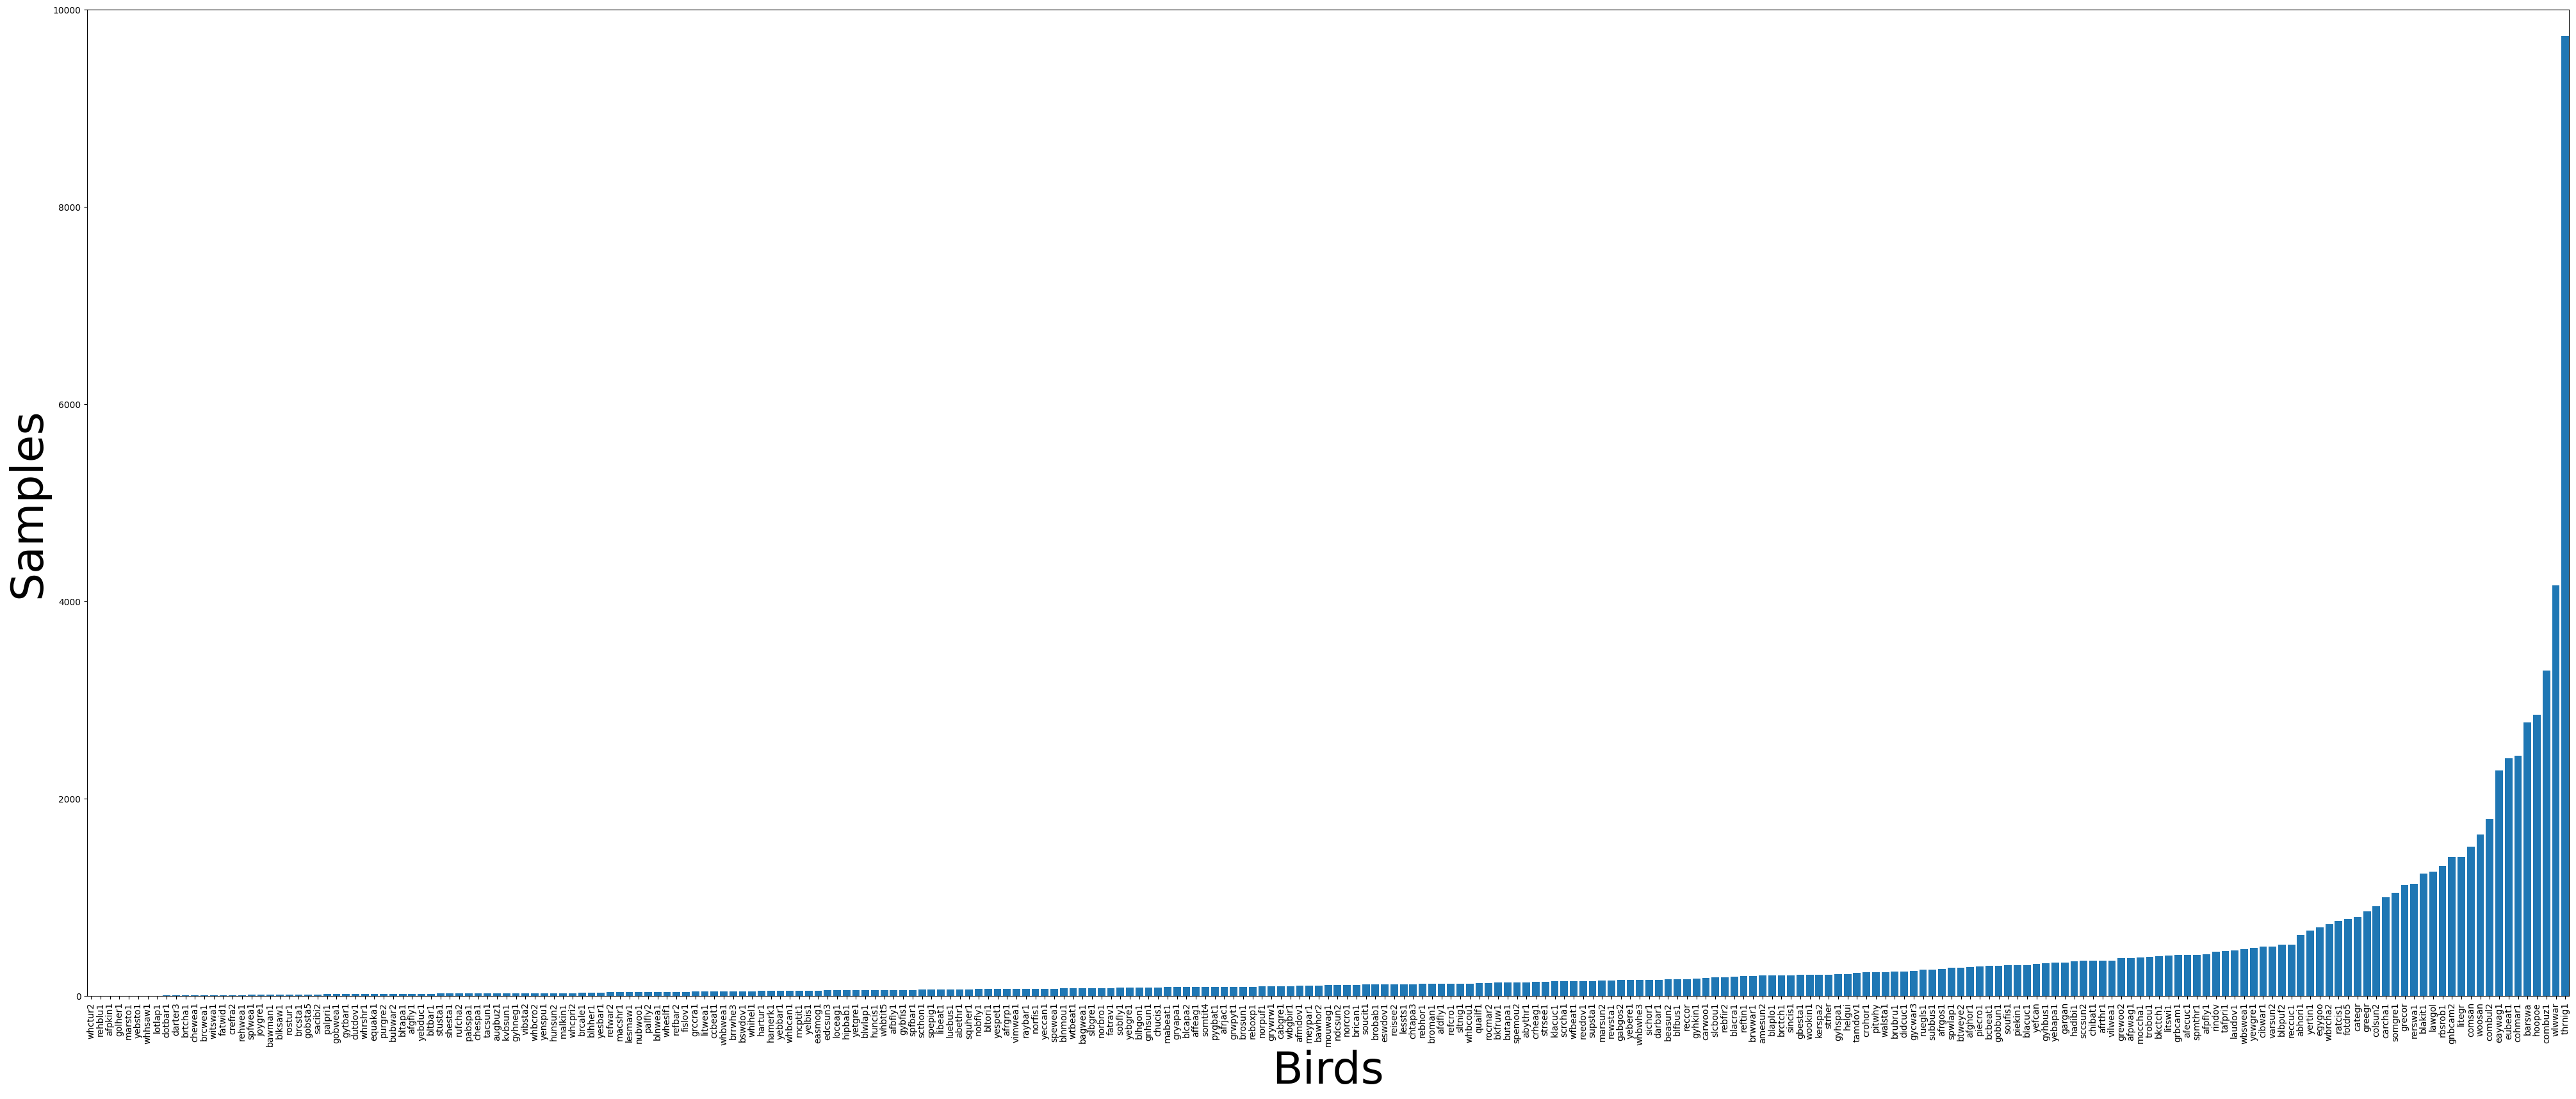

In [10]:
plt.figure(figsize=(50,20))
plt.bar(df['Bird'], df['Samples'])
plt.xlabel('Birds', fontsize=50)
plt.ylabel('Samples', fontsize=50)
plt.xticks(rotation=90, fontsize=10)
plt.ylim(0,10000)
plt.margins(x=0)
plt.show()

Creating the training files, one with the actual samples and one with the spectrograms saved as png pictures.

In [11]:
# Birds with more than 50 samples, birds with less samples were thrown out becuase sample quality is not reliable at low sample counts
df_1 = df[df['Samples'] >= 50]
df_1.shape

(192, 2)

In [12]:
def condition(folder_name, df):
    # Example: Select folders that start with the letter 'A'
    return folder_name in df['Bird'].values

subfolders = [f for f in os.listdir('final_samples') if os.path.isdir(os.path.join('final_samples', f))]

In [13]:
# Creating a zipfile with the audiofiles
atleast_50 = [f for f in subfolders if condition(f, df_1)]

with TemporaryDirectory() as tmp_dir:
    # Save DataFrame to CSV in the temporary directory
    csv_path = os.path.join(tmp_dir, 'atleast_50.csv')
    df_1.to_csv(csv_path, index=False)
    # Make folder inside zipfile with name sound samples
    main_folder_path = os.path.join(tmp_dir, 'sound samples')
    os.makedirs(main_folder_path, exist_ok=True)
    for subfolder in tqdm(atleast_50):
        subfolder_path = os.path.join('final_samples', subfolder)
        shutil.copytree(subfolder_path, os.path.join(main_folder_path, subfolder))

    shutil.make_archive('atleast_50', 'zip', tmp_dir)

  0%|          | 0/192 [00:00<?, ?it/s]

In [14]:
# Function for converting the samples to images
def return_image(filepath):
    y, sr = librosa.load(filepath, sr=None)
    melspec = librosa.feature.melspectrogram(y=y, sr=sr, hop_length=514) #Adjusting hop length so that image size is multiple of 8
    melspec_db = librosa.power_to_db(melspec, ref=np.max)
    min_db = melspec_db.min()
    max_db = melspec_db.max()
    # Rescaling to RGB scale
    scaled_melspec_db = (255 * (melspec_db - min_db) / (max_db - min_db)).astype(np.uint8)
    # Copying values to 3 channels so they work flawlessly with imagedatagenerators and pretrained models optimized for rgb images
    # But this way the information content does not change
    scaled_melspec_db_3channel = np.stack([scaled_melspec_db]*3, axis=-1)
    image = Image.fromarray(scaled_melspec_db_3channel)
    return image

# Function to convert audio samples to mel spectrogram images and copy them to a temporary directory.
def create_images_and_copy_to_tmp(subfolders, tmp_dir):
    for subfolder in tqdm(subfolders):
        subfolder_path = os.path.join('final_samples', subfolder)
        tmp_subfolder_path = os.path.join(tmp_dir, subfolder)
        os.makedirs(tmp_subfolder_path)

        for root, dirs, files in os.walk(subfolder_path):
            for file in files:
                if file.endswith(".ogg"):
                    ogg_filepath = os.path.join(root, file)
                    image = return_image(ogg_filepath)
                    image_path = os.path.join(tmp_subfolder_path, os.path.splitext(file)[0] + ".png")
                    image.save(image_path)

In [15]:
# Main code
atleast_50 = [f for f in subfolders if condition(f, df_1)]

with TemporaryDirectory() as tmp_dir:
    # Save DataFrame to CSV in the temporary directory
    csv_path_png = os.path.join(tmp_dir, 'atleast_50.csv')
    df_1.to_csv(csv_path_png, index=False)
    main_folder_path_png = os.path.join(tmp_dir, 'spectrograms')
    os.makedirs(main_folder_path_png, exist_ok=True)
    create_images_and_copy_to_tmp(atleast_50, main_folder_path_png)
    # Zip the temporary directory
    shutil.make_archive('atleast_50_png', 'zip', tmp_dir)

  0%|          | 0/192 [00:00<?, ?it/s]